<a href="https://colab.research.google.com/github/yanli499/ChatTime/blob/Lucy_1/YLL_Test_VGG_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ALL import statements
import os
import shutil
import copy
import time
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [8]:
# Mount our Google Drive
# re-run whenever needed
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Global variables
# classes are folders in each directory with these names
classes = ['afraid','angry','disgusted','happy','neutral','sad','surprised']

# emotion label for KDEF photos
emotion_code = {"AF":"afraid", "AN":"angry", "DI":"disgusted", "HA":"happy", 
                "NE":"neutral", "SA":"sad", "SU":"surprised"}

data_dir='/content/drive/My Drive/Colab Notebooks/Faces'

In [0]:
# Call this function once only!
"""
Logic for sorting thru dataseta for desired images:
KDEF:
- Example file name: AF01ANS.JPG
- Check:
    - length of name = 7, for straight profile only, ends with "S.jpg"
    - str[4:5] = {"AF":"afraid", "AN":"angry", "DI":"disgusted", "HA":"happy",
    "NE":"neutral", "SA":sad", "SU":"surprised"}
"""

def create_useful_dataset(): 
    # delete existing folder
    if os.path.exists(data_dir+'/'):
        shutil.rmtree(data_dir+'/')

    # make new directories for each emotion class + train, val, test
    try:
        os.mkdir(data_dir)

        for i in range(len(classes)):
            os.mkdir(data_dir+'/'+classes[i])

        os.mkdir(data_dir+'/train')
        for i in range(len(classes)):
            os.mkdir(data_dir+'/train/'+classes[i])
        
        os.mkdir(data_dir+'/val')
        for i in range(len(classes)):
            os.mkdir(data_dir+'/val/'+classes[i])

        os.mkdir(data_dir+'/test')
        for i in range(len(classes)):
            os.mkdir(data_dir+'/test/'+classes[i])

    except OSError:
        print ("Creation of the directories failed!")
    else:
        print ("Successfully created the directories!")

    # rootdir = path to KDEF main folder
    rootdir = '/content/drive/My Drive/Colab Notebooks/PROJECT/KDEF/'

    # go thru KDEF data + sort out desired photos
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            filename = subdir + os.sep + file
            if (file.endswith("S.jpg") or file.endswith("S.JPG")): 
                """
                For each straight profile photo:
                    - convert RGB --> Grayscale
                    - make 4 copies of photo: original orientation, rotate 5 degrees
                        clockwise (cw), rotate counter-clockwise (ccw), flip horizontally
                    - resize all to 256 x 256 pixels, b/c will center crop to 224 x 224 later
                    - then save in the corresponding emotion class folder
                """
                img = Image.open(filename).convert('L')
                img_cw = img.rotate(355)
                img_ccw = img.rotate(5)
                img_flip = img.transpose(Image.FLIP_LEFT_RIGHT)

                new_img = img.resize((256, 256))
                new_img_cw = img_cw.resize((256, 256))
                new_img_ccw = img_ccw.resize((256, 256))
                new_img_flip = img_flip.resize((256, 256))

                label = file[4:6]
                new_img.save(data_dir+'/'+emotion_code[label]+'/'+file)
                new_img_cw.save(data_dir+'/'+emotion_code[label]+'/'+'1'+file)
                new_img_ccw.save(data_dir+'/'+emotion_code[label]+'/'+'2'+file)
                new_img_flip.save(data_dir+'/'+emotion_code[label]+'/'+'3'+file)

In [0]:
def split_data_to_subsets():   
    # Split data into train, val, test datasets (60:20:20)
    # each class = ~568 images --> ~340 train, ~114 val, ~114 test

    # divide data into train, val, + test
    # for each emotion class, get filenames, shuffle, 
    # divide, move to corresponding folders
    for cla in classes:
        filepath = data_dir+'/'+cla
        names = []

        for file in os.listdir(filepath):
            names.append(file)

        random.shuffle(names)
        num_files = len(names)

        for ind, name in enumerate(names):
            if(ind <= math.ceil(0.6 * num_files)):
                # Move to train
                shutil.move(filepath+'/'+name, data_dir+'/train/'+cla+'/'+name)
            elif(ind <= math.ceil(0.8 * num_files)):
                # Move to val
                shutil.move(filepath+'/'+name, data_dir+'/val/'+cla+'/'+name)
            else:
                # Move to test
                shutil.move(filepath+'/'+name, data_dir+'/test/'+cla+'/'+name)

In [12]:
# Run only when necessary
create_useful_dataset()
split_data_to_subsets()

Successfully created the directories!


In [13]:
alexnet = torchvision.models.alexnet(pretrained=True)
vgg16 = torchvision.models.vgg16(pretrained=True)

torch.manual_seed(1) # set the random seed

classes = ['afraid','angry','disgusted','happy','neutral','sad','surprised']

data_dir='/content/drive/My Drive/Colab Notebooks/Faces/'

batch_size=1

# define training and test data directories
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

data_transform = transforms.Compose([transforms.CenterCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
    
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# delete existing folder
if os.path.exists(data_dir+'vgg16'):
    shutil.rmtree(data_dir+'vgg16')

try:
    os.mkdir(data_dir+'vgg16')

    os.mkdir(data_dir+'vgg16/train')
    for i in range(len(classes)):
        os.mkdir(data_dir+'vgg16/train/'+classes[i])
    
    os.mkdir(data_dir+'vgg16/val')
    for i in range(len(classes)):
        os.mkdir(data_dir+'vgg16/val/'+classes[i])

    os.mkdir(data_dir+'vgg16/test')
    for i in range(len(classes)):
        os.mkdir(data_dir+'vgg16/test/'+classes[i])

except OSError:
    print ("Creation of the directories failed!")
else:
    print ("Successfully created the directories!")


# delete existing folder
if os.path.exists(data_dir+'alexnet'):
    shutil.rmtree(data_dir+'alexnet')

try:
    os.mkdir(data_dir+'alexnet')

    os.mkdir(data_dir+'alexnet/train')
    for i in range(len(classes)):
        os.mkdir(data_dir+'alexnet/train/'+classes[i])
    
    os.mkdir(data_dir+'alexnet/val')
    for i in range(len(classes)):
        os.mkdir(data_dir+'alexnet/val/'+classes[i])

    os.mkdir(data_dir+'alexnet/test')
    for i in range(len(classes)):
        os.mkdir(data_dir+'alexnet/test/'+classes[i])

except OSError:
    print ("Creation of the directories failed!")
else:
    print ("Successfully created the directories!")



def save_tensor(dir_name, features, label, img_num):
  path='/content/drive/My Drive/Colab Notebooks/Faces/'+dir_name
  if (label.item() == 0):
    torch.save(features, path + '/afraid/features_' + str(img_num) + '.tensor')
  if (label.item() == 1):
    torch.save(features, path + '/angry/features_' + str(img_num) + '.tensor')
  if (label.item() == 2):
    torch.save(features, path + '/disgusted/features_' + str(img_num) + '.tensor')
  if (label.item() == 3):
    torch.save(features, path + '/happy/features_' + str(img_num) + '.tensor')
  if (label.item() == 4):
    torch.save(features, path + '/neutral/features_' + str(img_num) + '.tensor')
  if (label.item() == 5):
    torch.save(features, path + '/sad/features_' + str(img_num) + '.tensor')
  if (label.item() == 6):
    torch.save(features, path + '/surprised/features_' + str(img_num) + '.tensor')
  

i = 0
for img, label in train_loader:
    features = vgg16.features(img)
    save_tensor('vgg16/train', features, label, i)
    i+=1

i = 0
for img, label in val_loader:
    features = vgg16.features(img)
    save_tensor('vgg16/val', features, label, i)
    i+=1

i = 0
for img, label in test_loader:
    features = vgg16.features(img)
    save_tensor('vgg16/test', features, label, i)
    i+=1




i = 0
for img, label in train_loader:
    features = alexnet.features(img)
    save_tensor('alexnet/train', features, label, i)
    i+=1

i = 0
for img, label in val_loader:
    features = alexnet.features(img)
    save_tensor('alexnet/val', features, label, i)
    i+=1

i = 0
for img, label in test_loader:
    features = alexnet.features(img)
    save_tensor('alexnet/test', features, label, i)
    i+=1
    


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:01<00:00, 190MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 216MB/s]


Successfully created the directories!
Successfully created the directories!


In [0]:
#Artifical Neural Network Architecture
class ANNClassifier_Alexnet(nn.Module):
    def __init__(self):
        super(ANNClassifier_Alexnet, self).__init__()
        self.name = "alexnet_ann"
        self.fc1 = nn.Linear(256 * 6 * 6, 300)
        self.fc2 = nn.Linear(300, 7)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Artifical Neural Network Architecture
class ANNClassifier_VGG16(nn.Module):
    def __init__(self):
        super(ANNClassifier_VGG16, self).__init__()
        self.name = "vgg16_ann"
        self.fc1 = nn.Linear(512*7*7, 300)
        self.fc2 = nn.Linear(300, 7)

    def forward(self, x):
        x = x.view(-1, 512*7*7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
      
#output = model(features)
#prob = F.softmax(output)

In [0]:
def load_feature(loc): 
    return torch.load(loc)

# Data Loading
def get_data_loader(data_dir, batch_size):
  
    # mount our Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # define training and test data directories
    train_dir = os.path.join(data_dir, 'train/')
    val_dir = os.path.join(data_dir, 'val/')
    test_dir = os.path.join(data_dir, 'test/')

    # resize all images to 224 x 224
    #data_transform = transforms.Compose([transforms.CenterCrop(224), 
    #                                  transforms.ToTensor()])

    train_data = datasets.DatasetFolder(train_dir, loader = load_feature, extensions = '.tensor')
    val_data = datasets.DatasetFolder(val_dir, loader = load_feature, extensions = '.tensor')
    test_data = datasets.DatasetFolder(test_dir, loader = load_feature, extensions = '.tensor')

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader


# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
  
def get_accuracy(model, loader):

    correct = 0
    total = 0
    for imgs, labels in loader:

        imgs = torch.from_numpy(imgs.detach().numpy())
        
        output = model(imgs)
        prob = F.softmax(output)
        
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        
    return correct / total

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification acc over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    correct = 0
    total = 0
    for i, data in enumerate(loader, 0):
        imgs, labels = data
        
        imgs = torch.from_numpy(imgs.detach().numpy())
              
        out = model(imgs)             # forward pass
        prob = F.softmax(out)
        loss = criterion(prob, labels)
        
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        
        total_loss += loss
        total_epoch += len(labels)
    
    acc = correct / total
    loss = float(total_loss) / (i + 1)
    
    return acc, loss

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    
    n = len(train_acc) # number of epochs
    
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/'):

    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader = get_data_loader(data_dir, batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            
            # Get the inputs
            imgs, labels = data
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            imgs = torch.from_numpy(imgs.detach().numpy())
              
            out = model(imgs)             # forward pass
            prob = F.softmax(out)
            loss = criterion(prob, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss
            total_epoch += len(labels)
        train_acc[epoch] = get_accuracy(net, train_loader)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    
    print('Finished Training')
    
    # Write the train/test loss/accuracy into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [0]:
# from lab 3b tutorial

import matplotlib.pyplot as plt

def get_accuracy_alexnet(model, loader):

    correct = 0
    total = 0
    for imgs, labels in loader:
        
        imgs = torch.from_numpy(imgs.detach().numpy())
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, train_data, val_data, batch_size=20, num_epochs=1, learning_rate = 0.01):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            print(n)
            imgs = torch.from_numpy(imgs.detach().numpy())
              
            out = model(imgs)             # forward pass
            #prob = F.softmax(out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy_alexnet(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy_alexnet(model, val_loader))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

#Artifical Neural Network Architecture
class ANNClassifier2(nn.Module):
    def __init__(self):
        super(ANNClassifier2, self).__init__()
        self.fc1 = nn.Linear(512*7*7, 300)
        self.fc2 = nn.Linear(300, 7)

    def forward(self, x):
        x = x.view(-1, 512*7*7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [31]:
data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet/'

model = ANNClassifier_Alexnet()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=100,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.14285714285714285, Train loss: 2.095678630628084 |Validation acc: 0.14285714285714285, Validation loss: 2.038189615522112
Epoch 2: Train acc: 0.14285714285714285, Train loss: 2.0247969376413444 |Validation acc: 0.14285714285714285, Validation loss: 2.038189615522112
Epoch 3: Train acc: 0.14285714285714285, Train loss: 2.0247969376413444 |Validation acc: 0.14285714285714285, Validation loss: 2.038189615522112
Epoch 4: Train acc: 0.14285714285714285, Train loss: 2.0247969376413444 |Validation acc: 0.14285714285714285, Validation loss: 2.038189615522112
Epoch 5: Train acc: 0.14285714285714285, Train loss: 2.0247969376413444 |Validation acc: 0.14285714285714285, Validation loss: 2.038189615522112


KeyboardInterrupt: ignored

In [37]:
model = ANNClassifier_VGG16()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=100,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/vgg16')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.14285714285714285, Train loss: 2.1092952929045024 |Validation acc: 0.14285714285714285, Validation loss: 2.0381506511143277
Epoch 2: Train acc: 0.14285714285714285, Train loss: 2.0247834858141447 |Validation acc: 0.14285714285714285, Validation loss: 2.038170950753348
Epoch 3: Train acc: 0.14285714285714285, Train loss: 2.02478689896433 |Validation acc: 0.14285714285714285, Validation loss: 2.0381719044276645
Epoch 4: Train acc: 0.14285714285714285, Train loss: 2.0247873005114103 |Validation acc: 0.14285714285714285, Validation loss: 2.0381716319492886
Epoch 5: Train acc: 0.14285714285714285, Train loss: 2.02478689896433 |Validation acc: 0.14285714285714285, Validation loss: 2.0381712232317244
Epoch 6: Train acc: 0.14285714285714285, Train loss: 2.0247866981907894 |Validation acc: 0.14285714285714285, Validation loss: 2.03817081451416
Epoch 7: Train acc: 0.14285714285714285, Train loss: 2.0247864974172494 |Validation acc: 0.14285714285714285, Validation loss: 2.03

KeyboardInterrupt: ignored

In [35]:
model = ANNClassifier_VGG16()
train_net(model, batch_size=64, learning_rate=0.001, num_epochs=100,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/vgg16')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.14369256474519632, Train loss: 1.9963443153782894 |Validation acc: 0.14661654135338345, Validation loss: 1.945531258216271
Epoch 2: Train acc: 0.14369256474519632, Train loss: 1.9560410348992598 |Validation acc: 0.14661654135338345, Validation loss: 1.9439119192270131
Epoch 3: Train acc: 0.1695906432748538, Train loss: 1.9486750552528782 |Validation acc: 0.17794486215538846, Validation loss: 1.9430561065673828
Epoch 4: Train acc: 0.22389306599832914, Train loss: 1.9464438588995683 |Validation acc: 0.20676691729323307, Validation loss: 1.942198973435622
Epoch 5: Train acc: 0.3592314118629908, Train loss: 1.9447376853541325 |Validation acc: 0.33709273182957394, Validation loss: 1.9400752140925481
Epoch 6: Train acc: 0.3738512949039265, Train loss: 1.9448665819670026 |Validation acc: 0.3634085213032581, Validation loss: 1.937981972327599
Epoch 7: Train acc: 0.4494569757727652, Train loss: 1.9433328728926809 |Validation acc: 0.4298245614035088, Validation loss: 1.9349

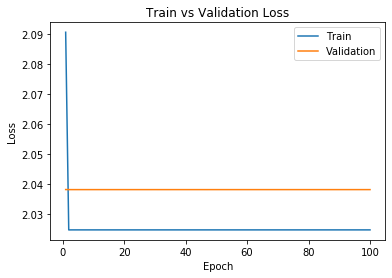

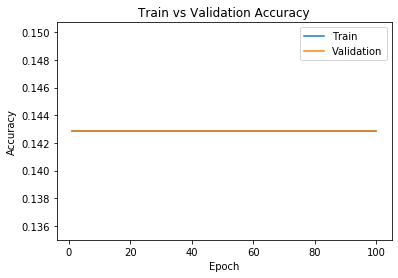

Final Training Accuracy: 0.14285714285714285
Final Validation Accuracy: 0.14285714285714285


In [21]:
model_path = get_model_name("alexnet_ann", batch_size=128, learning_rate=0.01, epoch=99)
plot_training_curve('/content/' + model_path)

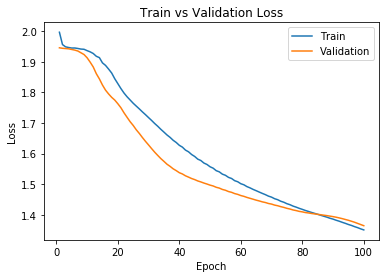

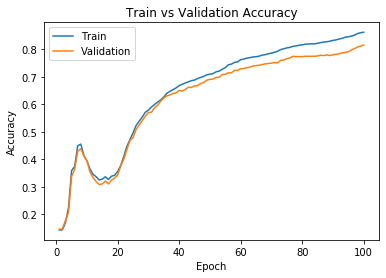

Final Training Accuracy: 0.8617376775271512
Final Validation Accuracy: 0.8157894736842105


In [36]:
model_path = get_model_name("vgg16_ann", batch_size=64, learning_rate=0.001, epoch=99)
plot_training_curve('/content/' + model_path)

In [0]:
model = ANNClassifier_Alexnet()
    
model_path = get_model_name("alexnet_ann", batch_size=128, learning_rate=0.01, epoch=99)
state = torch.load('/content/' + model_path)
model.load_state_dict(state)

data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet'

train_loader, val_loader, test_loader = get_data_loader(data_dir=data_dir, 
    batch_size=128)

criterion = nn.CrossEntropyLoss()
test_acc, test_loss = evaluate(model, test_loader, criterion)
print("Test classification accuracy:", test_acc)